In [33]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [34]:
train_transforms = transforms.Compose ([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose ([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/asl-alphabet'

train_dataset = datasets.ImageFolder('/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train', transform=train_transforms)
test_dataset = datasets.ImageFolder('/kaggle/input/asl-alphabet/asl_alphabet_test', transform=test_transforms)

#training_set = torchvision.datasets.CIFAR10(root=train_dataset, train=True,
                                        #download=True, transform=None)

split = list(range(0, len(train_dataset), 2))
new_train_dataset = torch.utils.data.Subset(train_dataset, split)

train_dataloader = torch.utils.data.DataLoader(new_train_dataset, batch_size=32,
                                             shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                             shuffle=True)


dataset_sizes = len(train_dataloader.dataset)
class_names = train_dataset.classes


# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


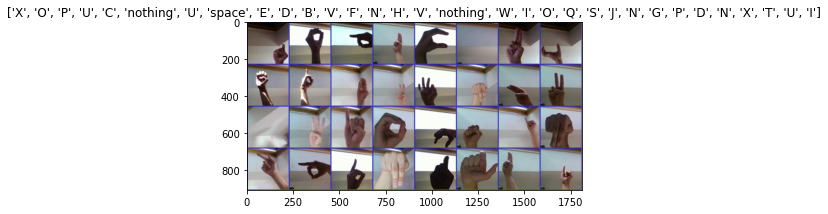

In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

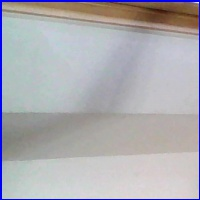

In [36]:
from IPython.display import Image, display
display(Image(filename="/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1989.jpg"))


In [37]:
#using resnet

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [38]:
criterion = nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean', label_smoothing=0.0) #TODO--------------

optimizer = optim.Adam(model.parameters(), lr=0.0001) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_acc = 0.0
    step = 0

    for epoch in range(num_epochs):
        
        

        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        

        model.train()
        running_loss = 0.0
        single_time = time.time()
        


            # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
          #if (i+1)%10!=0:
          #  continue

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          output = model(inputs)
          _, preds = torch.max(output, 1)
          loss = criterion(output, labels)


          loss.backward()
          optimizer.step()
          running_loss += loss.item()


          if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{dataset_sizes}, loss = {running_loss/dataset_sizes:.4f}')
            print(f'in {time.time() - single_time:.3f} seconds')
            single_time = time.time()


          scheduler.step()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

In [ ]:
num_epochs = 2

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs) #TODO-------



Epoch 1/2
----------
epoch 1 / 2, step 100/87000, loss = 0.0056
in 754.092 seconds
epoch 1 / 2, step 200/87000, loss = 0.0109
in 835.877 seconds
epoch 1 / 2, step 400/87000, loss = 0.0216
in 774.662 seconds
epoch 1 / 2, step 500/87000, loss = 0.0269
in 751.982 seconds
epoch 1 / 2, step 600/87000, loss = 0.0322
in 820.317 seconds
epoch 1 / 2, step 700/87000, loss = 0.0376
in 736.646 seconds
epoch 1 / 2, step 800/87000, loss = 0.0429
in 736.869 seconds
epoch 1 / 2, step 900/87000, loss = 0.0483
in 738.539 seconds
epoch 1 / 2, step 1000/87000, loss = 0.0537
in 738.984 seconds
epoch 1 / 2, step 1100/87000, loss = 0.0589
in 745.599 seconds
epoch 1 / 2, step 1200/87000, loss = 0.0643
in 733.627 seconds
epoch 1 / 2, step 1300/87000, loss = 0.0696
in 727.646 seconds


In [ ]:
def visualize_model(model, num_images):
    test_dataload = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                             shuffle=True)

    
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    

    with torch.no_grad():
        

        
        for inputs, labels in test_dataload:
            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

        

In [ ]:
visualize_model(model, 5)